In [2]:
from mistralai import Mistral
import requests
import numpy as np
import faiss
import os
from getpass import getpass

# <font color='red'>1 - </font> Getting Data

#### <font color='red'>1.a </font> Read the csv

In [3]:
path = "../dataset/data/"

In [4]:
import pandas as pd
import glob

df = pd.read_csv("../dataset/data/dataset-tickets-multi-lang3-4k.csv")

df = df.fillna('')

df.head()

,subject,body,answer,type,queue,priority,language,business_type,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9
0,Problema crítico del servidor requiere atenció...,Es necesaria una investigación inmediata sobre...,Estamos investigando urgentemente el problema ...,Incident,Technical Support,high,es,IT Services,Urgent Issue,Service Disruption,Incident Report,Service Recovery,System Maintenance,,,,
1,Anfrage zur Verfügbarkeit des Dell XPS 13 9310,"Sehr geehrter Kundenservice,\n\nich hoffe, die...","Sehr geehrter <name>,\n\nvielen Dank, dass Sie...",Request,Customer Service,low,de,Tech Online Store,Sales Inquiry,Product Support,Customer Service,Order Issue,Returns and Exchanges,,,,
2,Erro na Autocompletação de Código do IntelliJ ...,"Prezado Suporte ao Cliente <name>,\n\nEstou es...","Prezado <name>,\n\nObrigado por entrar em cont...",Incident,Technical Support,high,pt,IT Services,Technical Support,Software Bug,Problem Resolution,Urgent Issue,IT Support,,,,
3,Urgent Assistance Required: AWS Service,"Dear IT Services Support Team, \n\nI am reachi...","Dear <name>,\n\nThank you for reaching out reg...",Request,IT Support,high,en,IT Services,IT Support,Urgent Issue,Service Notification,Cloud Services,Problem Resolution,Technical Guidance,Performance Tuning,,
4,Problème d'affichage de MacBook Air,Cher équipe de support du magasin en ligne Tec...,"Cher <name>,\n\nMerci de nous avoir contactés ...",Incident,Product Support,low,fr,Tech Online Store,Technical Support,Product Support,Hardware Failure,Service Recovery,Routine Request,,,,


#### <font color='red'>1.b </font> Create one string per dataframe line

In [75]:
import numpy as np

def format_ticket(row):
    return (
        f"SUBJECT: {row['subject']} "
        f"PROBLEM: {row['body']} "
        f"SOLUTION: {row['answer']} "
        f"PRIORITY: {row['priority']} "
        f"LANGUAGE: {row['language']} "
        f"SUPPORT TEAM: {row['queue']}"
    )

texts = df.apply(format_ticket, axis=1)
lengths = texts.str.len()

print("mean of each line sample length", np.mean(lengths))
print("max of length line sample", np.max(lengths))

mean of each line sample length 1630.032
max of length line sample 5026


In [ ]:
print(texts[0])

SUBJECT: Problema crítico del servidor requiere atención inmediata PROBLEM: Es necesaria una investigación inmediata sobre la interrupción en el servicio de gestión de AWS que está impactando funciones comerciales esenciales. SOLUTION: Estamos investigando urgentemente el problema con el servicio de gestión de AWS. Proporcionaremos actualizaciones sobre nuestro progreso. PRIORITY: high LANGUAGE: es SUPPORT TEAM: Technical Support


#### <font color='red'>1.c </font> Split the data into train test to be able to test rag on unseen data

In [76]:
from sklearn.model_selection import train_test_split

train_idx, test_idx = train_test_split(np.arange(len(df)), random_state=42)

# <font color='red'>2 - </font> Split document into chunks

#### <font color='red'>2.a </font> Create chunks

In [77]:
import re

chunk_size = 2048
chunks = []

for idx in train_idx:
    text = texts[idx]
    #if less than 500 length we keep the entire string as a chunk
    if len(text) < 500:
        chunks.append(text)
    else:
        #using regex to cut the text into sections
        sections = re.split(r"(SUBJECT:*|PROBLEM:*|SOLUTION:*|PRIORITY:*|LANGUAGE:*|SUPPORT TEAM:*)", text)
        sections = [s.strip() for s in sections if s.strip()]
        it = iter(sections)
        sections_list = [f"{k} {v}" for k, v in zip(it, it)]

        temp_chunk = ""
        for sec in sections_list:
            #if temp_chunk + new sec is greater than the chunk size, we save the last temp chunk
            if len(temp_chunk) + len(sec) > chunk_size:
                if temp_chunk:  #no empty chunk
                    chunks.append(temp_chunk.strip())
                temp_chunk = sec
            else:
                temp_chunk += " " + sec if temp_chunk else sec
        #adding last chunk
        if temp_chunk:
            chunks.append(temp_chunk.strip())

In [79]:
print("total number of chunks :", len(chunks))

total number of chunks : 4025


#### <font color='red'>2.b </font> Monitor chunk size

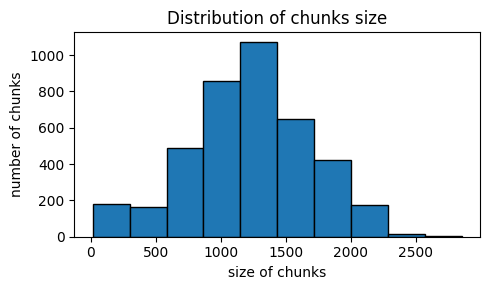

In [10]:
import matplotlib.pyplot as plt

chunks_length = [len(chunk) for chunk in chunks]
plt.figure(figsize=(5, 3))
plt.title("Distribution of chunks size")
plt.xlabel("size of chunks")
plt.ylabel("number of chunks")
plt.hist(chunks_length, bins=10, edgecolor='k')
plt.tight_layout()

# <font color='red'>3 - </font> Create embeddings for each text chunk

In [ ]:
from sentence_transformers import SentenceTransformer

embeddings_model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2') #multilingual model
embeddings = embeddings_model.encode(chunks)

# <font color='red'>4 - </font> Load into a vector database

In [12]:
import faiss

d = embeddings.shape[1]
index = faiss.IndexFlatL2(d)
index.add(embeddings)

# <font color='red'>5 - </font> Prepocess data input/output for RAG

#### <font color='red'>5.a </font> Create rag input from formatted str

In [80]:
import json

def expected_input(texts, test_idx, idx, embeddings_model):
    
    ticket_sample = texts[test_idx[idx]]
    ticket_sample_problem = re.search(r"PROBLEM:(.*?)(?=SUBJECT:|SOLUTION:|PRIORITY:|LANGUAGE:|SUPPORT TEAM:|$)", ticket_sample, re.DOTALL).group(1).strip()
    ticket_sample_embeddings = embeddings_model.encode(ticket_sample_problem).reshape(1, -1)
    
    #top k similar ticket problem
    D, I = index.search(ticket_sample_embeddings, k=3)
    retrieved_chunk = [chunks[i] for i in I.tolist()[0]]
    
    return ticket_sample_problem, retrieved_chunk

#### <font color='red'>5.b </font> Create rag output ref to compare predictions to

In [ ]:
def expected_output(texts, test_idx, idx):
    
    ticket_sample = texts[test_idx[idx]]
    ticket_sample_answer = re.search(r"SOLUTION:(.*?)(?=SUBJECT:|PROBLEM:|PRIORITY:|LANGUAGE:|SUPPORT TEAM:|$)", ticket_sample, re.DOTALL).group(1).strip()
    ticket_sample_priority = re.search(r"PRIORITY:(.*?)(?=SUBJECT:|PROBLEM:|SOLUTION:|LANGUAGE:|SUPPORT TEAM:|$)", ticket_sample, re.DOTALL).group(1).strip()
    ticket_sample_team = re.search(r"SUPPORT TEAM:(.*?)(?=SUBJECT:|SOLUTION:|PROBLEM:|SOLUTION:|LANGUAGE:|$)", ticket_sample, re.DOTALL).group(1).strip()
    ticket_sample_lg = re.search(r"LANGUAGE:(.*?)(?=SUBJECT:|SOLUTION:|PROBLEM:|SOLUTION:|SUPPORT TEAM:|$)", ticket_sample, re.DOTALL).group(1).strip()

    data = {
    "answer": ticket_sample_answer,
    "priority": ticket_sample_priority,
    "support_team": ticket_sample_team,
    "language": ticket_sample_lg
    }
    
    return json.dumps(data, indent=4)

# <font color='red'>6 - </font> Testing RAG on some test samples

#### <font color='red'>6.a </font> Connexion to Mistral api

In [ ]:
api_key = os.environ["MISTRAL_API_KEY"]
client = Mistral(api_key=api_key)

def run_mistral(user_message, model="mistral-medium-2505"):
    messages = [
        {
            "role": "user", "content": user_message
        }
    ]
    chat_response = client.chat.complete(
        model=model,
        messages=messages,
        response_format={"type": "json_object"} #it must match our ref output
    )
    return (chat_response.choices[0].message.content)

#### <font color='red'>6.b </font> RAG on few test sample, storing priority and support team in output

In [52]:
from tqdm import tqdm

ref_priority, ref_support_team = [], []
pred_priority, pred_support_team = [], []

for test in tqdm(range(100)):
    ticket_sample_problem, retrieved_chunk = expected_input(texts, test_idx, test, embeddings_model)

    prompt = f"""
        Context information is below.
        ---------------------
        {retrieved_chunk}
        ---------------------
        Given the context information and not prior knowledge, answer the query.
        Query: {ticket_sample_problem}

        CRITICAL: You MUST return ONLY a valid JSON object with exactly this structure. 
        Do not include any explanatory text, markdown formatting, or additional content.
        Return only the JSON object with these exact field names and value types:

        {{
            "answer": "your response text here",
            "priority": "low",
            "support_team": "Technical Support", 
            "language": "en"
        }}

        Rules:
        - priority must be exactly one of: "low", "medium", "high"
        - support_team must be exactly one of: "Technical Support", "Customer Service", "IT Support", "Product Support", "Billing and Payments", "Service Outages and Maintenance", "General Inquiry", "Returns and Exchanges", "Sales and Pre-Sales", "Human Resources"
        - language must be exactly one of: "es", "de", "pt", "en", "fr"
        - All values must be simple strings, not objects
        - Return ONLY the JSON object, nothing else

        JSON:
        """
    
    responses = run_mistral(prompt)
    ref_output = expected_output(texts, test_idx, test)

    pred_priority.append(json.loads(responses)['priority'])
    pred_support_team.append(json.loads(responses)['support_team'])

    ref_priority.append(json.loads(ref_output)['priority'])
    ref_support_team.append(json.loads(ref_output)['support_team'])

100%|██████████| 100/100 [10:09<00:00,  6.09s/it]


# <font color='red'>7 - </font> Measure Classification efficiency

#### <font color='red'>7.a </font> Storing results

In [65]:
df_priority = pd.DataFrame({"ref_priority" : ref_priority,
               "pred_priority" : pred_priority})

df_support_teams = pd.DataFrame({"ref_support_team" : ref_support_team,
               "pred_support_team" : pred_support_team})

In [68]:
df_priority.to_csv("../results/priority.csv", index_label=False)
df_support_teams.to_csv("../results/support_team.csv", index_label=False)

#### <font color='red'>7.b </font> Encoding classifications output to calculate f1 score

In [56]:
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
encoded_ref_priority = label_encoder.fit_transform(ref_priority)
encoded_pred_priority = label_encoder.transform(pred_priority)

label_encoder = LabelEncoder()
encoded_ref_support_team = label_encoder.fit_transform(ref_support_team)
encoded_pred_support_team = label_encoder.transform(pred_support_team)

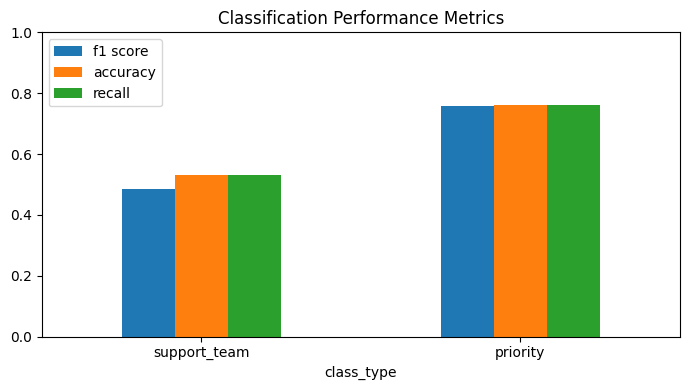

In [111]:
from sklearn.metrics import f1_score, accuracy_score, recall_score

df_score = pd.DataFrame(
    {
        "class_type" : ["support_team", "priority"],
        "f1 score" : [f1_score(encoded_ref_support_team, encoded_pred_support_team, average="weighted"),
                      f1_score(encoded_ref_priority, encoded_pred_priority, average="weighted")],

        "accuracy" : [accuracy_score(encoded_ref_support_team, encoded_pred_support_team),
                      accuracy_score(encoded_ref_priority, encoded_pred_priority)],

        "recall" : [recall_score(encoded_ref_support_team, encoded_pred_support_team, average="weighted"),
                    recall_score(encoded_ref_priority, encoded_pred_priority, average="weighted")]
    }
)

df_score.plot(x='class_type', y=['f1 score', 'accuracy', 'recall'], kind='bar', figsize=(7, 4))
plt.title("Classification Performance Metrics")
plt.xticks(rotation=0)
plt.ylim(0,1)
plt.tight_layout()

# <font color='red'>8 - </font> Context Relevance

In [21]:
from ragas.dataset_schema import SingleTurnSample, EvaluationDataset

samples = []

for idx in test_idx[:100]:
    ticket_sample = texts[idx]
    ticket_sample_problem = re.search(r"PROBLEM:(.*?)(?=SUBJECT:|SOLUTION:|PRIORITY:|LANGUAGE:|SUPPORT TEAM:|$)", ticket_sample, re.DOTALL).group(1).strip()
    ticket_sample_answer = re.search(r"SOLUTION:(.*?)(?=SUBJECT:|SOLUTION:|PRIORITY:|LANGUAGE:|SUPPORT TEAM:|$)", ticket_sample, re.DOTALL).group(1).strip()
    ticket_sample_embeddings = embeddings_model.encode(ticket_sample).reshape(1, -1)
    
    D, I = index.search(ticket_sample_embeddings, k=3)
    retrieved_chunk = [chunks[i] for i in I.tolist()[0]]
    retrieved_chunk

    samples.append(SingleTurnSample(
        user_input=ticket_sample_problem,
        retrieved_contexts=retrieved_chunk,
        response=ticket_sample_answer
    ))

eval_dataset = EvaluationDataset(samples=samples)

In [22]:
from ragas.metrics import LLMContextPrecisionWithoutReference
from ragas.embeddings import LangchainEmbeddingsWrapper
from ragas.llms import LangchainLLMWrapper
from langchain_mistralai.chat_models import ChatMistralAI

mistral_wrapper = ChatMistralAI(model="mistral-small-2506")
judge_llm = LangchainLLMWrapper(mistral_wrapper)
embeddings_wrapper = LangchainEmbeddingsWrapper(embeddings_model)

context_precision = LLMContextPrecisionWithoutReference(llm=judge_llm)

In [23]:
from ragas import evaluate

result = evaluate(
    dataset=eval_dataset,
    metrics=[context_precision],
    llm=judge_llm,
    embeddings=embeddings
)

Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]

In [26]:
print("Score de Context Precision :", np.mean(result['llm_context_precision_without_reference']))

Score de Context Precision : 0.9216666666254166


# <font color='red'>9 - </font> LLM as a judge

In [27]:
from pydantic import BaseModel, Field
from enum import Enum

# Initialize the Mistral client with the API key
client = Mistral(api_key=api_key)
model = "mistral-medium-latest"

# Define Enum for scores
class Score(str, Enum):
    no_relevance = "0"
    low_relevance = "1"
    medium_relevance = "2"
    high_relevance = "3"

# Define a constant for the score description
SCORE_DESCRIPTION = (
    "Score as a string between '0' and '3'. "
    "0: No relevance/Not grounded/Irrelevant - The context/answer is completely unrelated or not based on the context. "
    "1: Low relevance/Low groundedness/Somewhat relevant - The context/answer has minimal relevance or grounding. "
    "2: Medium relevance/Medium groundedness/Mostly relevant - The context/answer is somewhat relevant or grounded. "
    "3: High relevance/High groundedness/Fully relevant - The context/answer is highly relevant or grounded."
)

# Define separate classes for each criterion with detailed descriptions
class ContextRelevance(BaseModel):
    explanation: str = Field(..., description=("Step-by-step reasoning explaining how the retrieved context aligns with the user's query. "
                    "Consider the relevance of the information to the query's intent and the appropriateness of the context "
                    "in providing a coherent and useful response."))
    score: Score = Field(..., description=SCORE_DESCRIPTION)

class AnswerRelevance(BaseModel):
    explanation: str = Field(..., description=("Step-by-step reasoning explaining how well the generated answer addresses the user's original query. "
                    "Consider the helpfulness and on-point nature of the answer, aligning with the user's intent and providing valuable insights."))
    score: Score = Field(..., description=SCORE_DESCRIPTION)

class Groundedness(BaseModel):
    explanation: str = Field(..., description=("Step-by-step reasoning explaining how faithful the generated answer is to the retrieved context. "
                    "Consider the factual accuracy and reliability of the answer, ensuring it is grounded in the retrieved information."))
    score: Score = Field(..., description=SCORE_DESCRIPTION)

class RAGEvaluation(BaseModel):
    context_relevance: ContextRelevance = Field(..., description="Evaluation of the context relevance to the query, considering how well the retrieved context aligns with the user's intent." )
    answer_relevance: AnswerRelevance = Field(..., description="Evaluation of the answer relevance to the query, assessing how well the generated answer addresses the user's original query." )
    groundedness: Groundedness = Field(..., description="Evaluation of the groundedness of the generated answer, ensuring it is faithful to the retrieved context." )

# Function to evaluate RAG metrics
def evaluate_rag(query: str, retrieved_context: str, generated_answer: str):
    chat_response = client.chat.parse(
        model=model,
        messages=[
            {
                "role": "system",
                "content": (
                    "You are a judge for evaluating a Retrieval-Augmented Generation (RAG) system. "
                    "Evaluate the context relevance, answer relevance, and groundedness based on the following criteria: "
                    "Provide a reasoning and a score as a string between '0' and '3' for each criterion. "
                    "Context Relevance: How relevant is the retrieved context to the query? "
                    "Answer Relevance: How relevant is the generated answer to the query? "
                    "Groundedness: How faithful is the generated answer to the retrieved context?"
                )
            },
            {
                "role": "user",
                "content": f"Query: {query}\nRetrieved Context: {retrieved_context}\nGenerated Answer: {generated_answer}"
            },
        ],
        response_format=RAGEvaluation,
        temperature=0
    )
    return chat_response.choices[0].message.parsed

In [28]:
sample_idx = test_idx[10]

query = re.search(r"PROBLEM:(.*?)(?=SUBJECT:|SOLUTION:|PRIORITY:|LANGUAGE:|SUPPORT TEAM:|$)", ticket_sample, re.DOTALL).group(1).strip()
generated_answer = re.search(r"SOLUTION:(.*?)(?=SUBJECT:|SOLUTION:|PRIORITY:|LANGUAGE:|SUPPORT TEAM:|$)", ticket_sample, re.DOTALL).group(1).strip()
ticket_sample_embeddings = embeddings_model.encode(ticket_sample).reshape(1, -1)    
D, I = index.search(ticket_sample_embeddings, k=3)
retrieved_context = [chunks[i] for i in I.tolist()[0]]
evaluation = evaluate_rag(query, retrieved_context, generated_answer)

# Print the evaluation
print("RAG Evaluation:")
print("\nCriteria: Context Relevance")
print(f"Reasoning: {evaluation.context_relevance.explanation}")
print(f"Score: {evaluation.context_relevance.score.value}/3")

print("\nCriteria: Answer Relevance")
print(f"Reasoning: {evaluation.answer_relevance.explanation}")
print(f"Score: {evaluation.answer_relevance.score.value}/3")

print("\nCriteria: Groundedness")
print(f"Reasoning: {evaluation.groundedness.explanation}")
print(f"Score: {evaluation.groundedness.score.value}/3")

RAG Evaluation:

Criteria: Context Relevance
Reasoning: The retrieved context is highly relevant to the query. The context includes multiple examples of customers requesting help and optimization for their AWS Management Service, which directly aligns with the user's query. The contexts are in different languages but convey the same intent and requirements as the user's query.
Score: 3/3

Criteria: Answer Relevance
Reasoning: The generated answer is highly relevant to the query. It directly addresses the user's request for expert help in setting up and optimizing their AWS Management Service. The answer acknowledges the user's query and provides a clear next step, which is what the user is seeking.
Score: 3/3

Criteria: Groundedness
Reasoning: The generated answer is faithful to the retrieved context. It follows the pattern seen in the context where the support team acknowledges the request and promises to have an expert team contact the user. This aligns well with the solutions provid